# I) Importation des modules néccéssaires

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

SystemError: initialization of _pywrap_checkpoint_reader raised unreported exception

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# II) Chargement des images

In [5]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [6]:
PATH_DATA = f'./images/'

content_path_1 = tf.io.read_file(str(PATH_DATA + 'men.png'))
content_path_1 = tf.io.decode_jpeg(content_path_1)
content_path_2 = tf.io.read_file(str(PATH_DATA + 'women.png'))
content_path_2 = tf.io.decode_jpeg(content_path_2)
style_path = tf.io.read_file(str(PATH_DATA + 'Cover-peinture.jpg'))
style_path = tf.io.decode_jpeg(style_path)

### Fonction qui charge une image et l'affiche avec une dimension maximale de 512 pixels

In [7]:
def load_img(image):
  max_dim = 512
  img = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

### Fonction qui affiche l'image

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

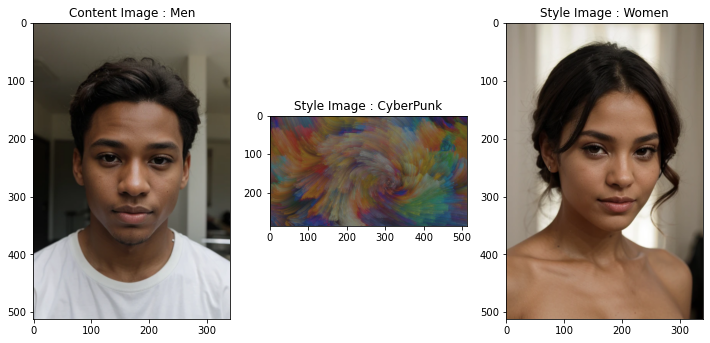

In [9]:
content_image_1 = load_img(content_path_1)
content_image_2 = load_img(content_path_2)
style_image = load_img(style_path)

plt.subplot(1, 3, 1)
imshow(content_image_1, 'Content Image : Men')

plt.subplot(1, 3, 2)
imshow(style_image, 'Style Image : CyberPunk')

plt.subplot(1, 3, 3)
imshow(content_image_2, 'Style Image : Women')

# Définir les représentations de contenu et de style

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_image_1*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [11]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('lab_coat', 0.5385658),
 ('barbershop', 0.03767817),
 ('ping-pong_ball', 0.020274246),
 ('stethoscope', 0.018661212),
 ('plate', 0.016990589)]

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Choisissez des couches intermédiaires du réseau pour représenter le style et le contenu de l'image

In [13]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Construction du modèle

In [14]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [15]:
# Création du modèle

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 288, 512, 64)
  min:  0.0
  max:  414.5351
  mean:  16.961044

block2_conv1
  shape:  (1, 144, 256, 128)
  min:  0.0
  max:  1742.0336
  mean:  79.46339

block3_conv1
  shape:  (1, 72, 128, 256)
  min:  0.0
  max:  4759.9053
  mean:  77.22693

block4_conv1
  shape:  (1, 36, 64, 512)
  min:  0.0
  max:  10540.97
  mean:  325.0595

block5_conv1
  shape:  (1, 18, 32, 512)
  min:  0.0
  max:  1324.9612
  mean:  24.97114



## Calcul du style

In [16]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extraction du style et du contenu

In [17]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [18]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image_1))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0095840115
    max:  19873.844
    mean:  244.20255

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  30747.174
    mean:  6149.5913

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  149426.97
    mean:  6104.3633

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1162509.8
    mean:  105670.77

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  250252.22
    mean:  1150.285

Contents:
   block5_conv2
    shape:  (1, 32, 21, 512)
    min:  0.0
    max:  1331.191
    mean:  13.776243


## Exécution de la descente de pente

In [19]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image_1)['content']

In [20]:
image = tf.Variable(content_image_1)

In [21]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [22]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [23]:
style_weight=1e-2
content_weight=1e4

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [25]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

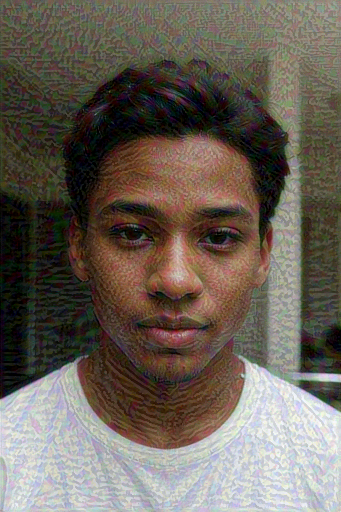

In [26]:
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

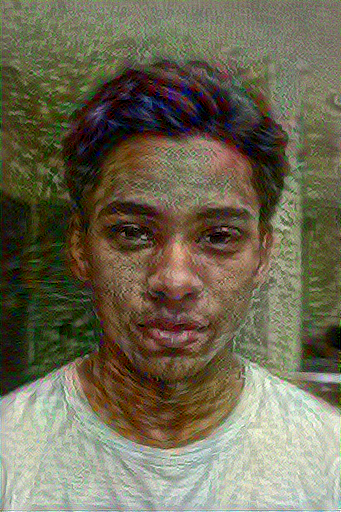

Train step: 100
Total time: 491.9


In [27]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Perte de variation totale

In [28]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

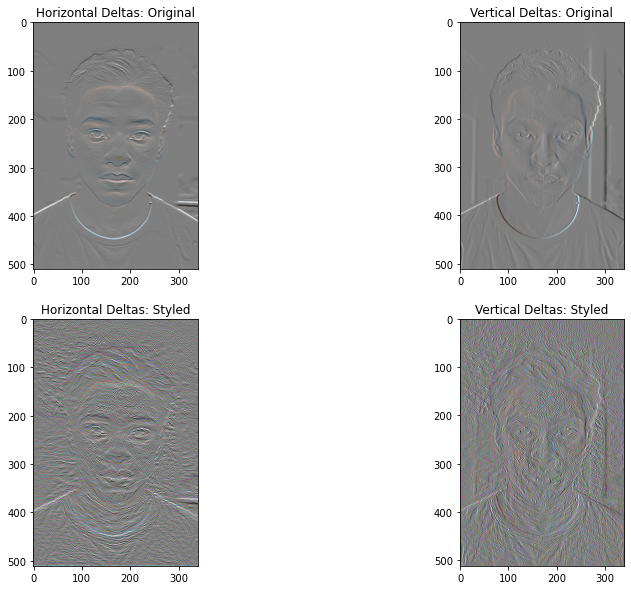

In [29]:
x_deltas, y_deltas = high_pass_x_y(content_image_1)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

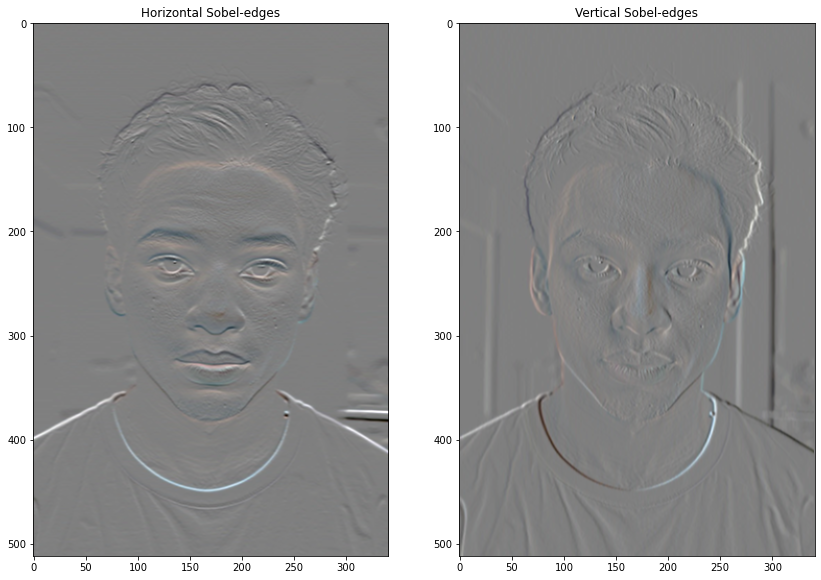

In [30]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image_1)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [31]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [32]:
total_variation_loss(image).numpy()

57908.58

In [33]:
tf.image.total_variation(image).numpy()

array([57908.58], dtype=float32)

# Relancer l'optimisation

In [37]:
total_variation_weight=30

In [44]:
opt_1 = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [45]:
@tf.function()
def final_train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt_1.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [46]:
image = tf.Variable(content_image_1)

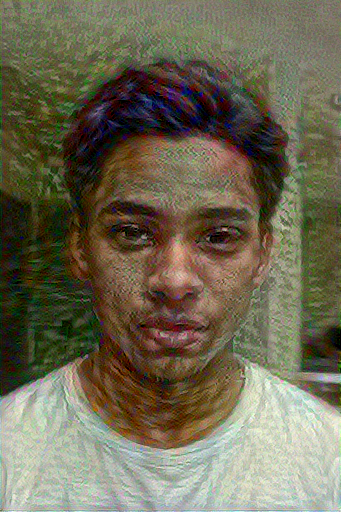

Train step: 100
Total time: 460.8


In [48]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    final_train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [1]:
# Sauvegarde du resultat

file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

NameError: name 'tensor_to_image' is not defined

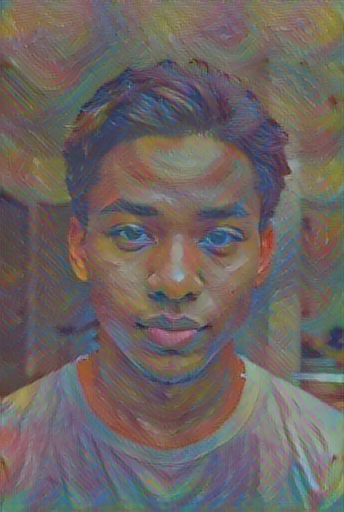

In [49]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image_1), tf.constant(style_image))[0]
tensor_to_image(stylized_image)